Diabetes
In this dataset you have 3 different outputs:
1.	No readmission;
2.	A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
3.	A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.
Your task is either to classify a patient-hospital outcome or to cluster them aiming at finding patterns that give a distinct insight.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available for us, i.e. github.

Hint to success in your quest: Develop and stay clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over.

You have up to a day before the technical interview to share your results of this test.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import re

In [2]:
df_diabetes = pd.read_csv('.\\data\\diabetic_data.csv')

In [3]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### TRATAMIENTO DE MISING VALUES Y ANALISIS DE NULOS

In [4]:
df_diabetes.replace('?', np.nan, inplace=True)

missing_data = df_diabetes.isnull().sum()
missing_percentage = (missing_data / df_diabetes.size) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})

print(missing_info)

                          Missing Values  Percentage
encounter_id                           0    0.000000
patient_nbr                            0    0.000000
race                                2273    0.044671
gender                                 0    0.000000
age                                    0    0.000000
weight                             98569    1.937170
admission_type_id                      0    0.000000
discharge_disposition_id               0    0.000000
admission_source_id                    0    0.000000
time_in_hospital                       0    0.000000
payer_code                         40256    0.791148
medical_specialty                  49949    0.981644
num_lab_procedures                     0    0.000000
num_procedures                         0    0.000000
num_medications                        0    0.000000
number_outpatient                      0    0.000000
number_emergency                       0    0.000000
number_inpatient                       0    0.

Se toma la decisión de eliminar las columnas con presencia de nulos mayor a 5% y mantener las columnas con nulos menores a ese umbral pero eliminar las filas nulas de estas variables.

Columnas a eliminar:
- weight
- payer_code
- medical_specialty
- max_glu_serum
- A1Cresult

In [5]:
threshold_column = 0.05
columns_to_drop = missing_info[missing_info['Percentage'] > threshold_column].index
df_diabetes_cleaned_columns = df_diabetes.drop(columns=columns_to_drop)

threshold_row = 0.05
rows_to_drop = missing_info[missing_info['Percentage'] < threshold_row].index
df_diabetes_cleaned = df_diabetes_cleaned_columns.dropna(subset=rows_to_drop)

print("Shape del DataFrame después de limpiar:", df_diabetes_cleaned.shape)
print(df_diabetes_cleaned.info())

Shape del DataFrame después de limpiar: (98053, 45)
<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  object
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98

#### TARGET

In [6]:
readmitted_unique = df_diabetes_cleaned['readmitted'].unique()
print(readmitted_unique)

['>30' 'NO' '<30']


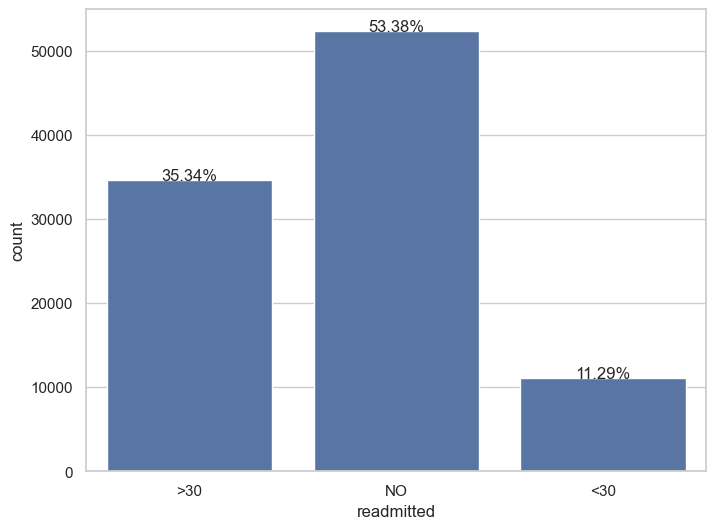

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='readmitted', data=df_diabetes_cleaned)

total = float(len(df_diabetes_cleaned))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.5,
            '{:.2%}'.format(height/total),
            ha="center")

plt.show()

La variable objetivo muestra un desbalance de clases lo cual implica que pueda ser necesario aplicar alguna tecninca de balanceo de clases como SMOTE, oversampling o undersampling.

In [8]:
target_count = df_diabetes_cleaned['readmitted'].value_counts()
target_count

readmitted
NO     52338
>30    34649
<30    11066
Name: count, dtype: int64

Se decide mapear la variable objetivo

In [9]:
readmitted_mapping = {'NO': 1, '>30': 2, '<30': 3}
df_diabetes_cleaned['readmitted_mapped'] = df_diabetes_cleaned['readmitted'].map(readmitted_mapping)

C:\Users\marti\AppData\Local\Temp\ipykernel_33288\1588019345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetes_cleaned['readmitted_mapped'] = df_diabetes_cleaned['readmitted'].map(readmitted_mapping)


#### VARIABLES NUMERICAS

In [10]:
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 
                    'number_inpatient', 'number_diagnoses']

#### VARIABLES CATEGORICAS

In [11]:
var_persona = ['race', 'gender', 'age']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone''change', 'diabetesMed']


#### ANALISIS DE VARIABLES NUMERICAS

In [12]:
df_diabetes_cleaned[var_numericas].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000
mean,4.421976,43.148073,1.350749,16.119650,0.376378,0.202462,0.646864,7.512060
std,2.993074,19.712033,1.708506,8.108476,1.283359,0.942892,1.271020,1.832497
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Se genera matriz de correlación para determinar si existen relaciones altas entre variables numericas.
Se utilizan lso metodos "pearson" y "spearman" para comparar resultados
Se detecta que hay una correlación de 0.47 entre "num_medications" y "time_in_hospital" pero se decide avanzar con ambas variables. Se tendrá en cuenta este hecho en caso de que afecte a la performance del modelo.

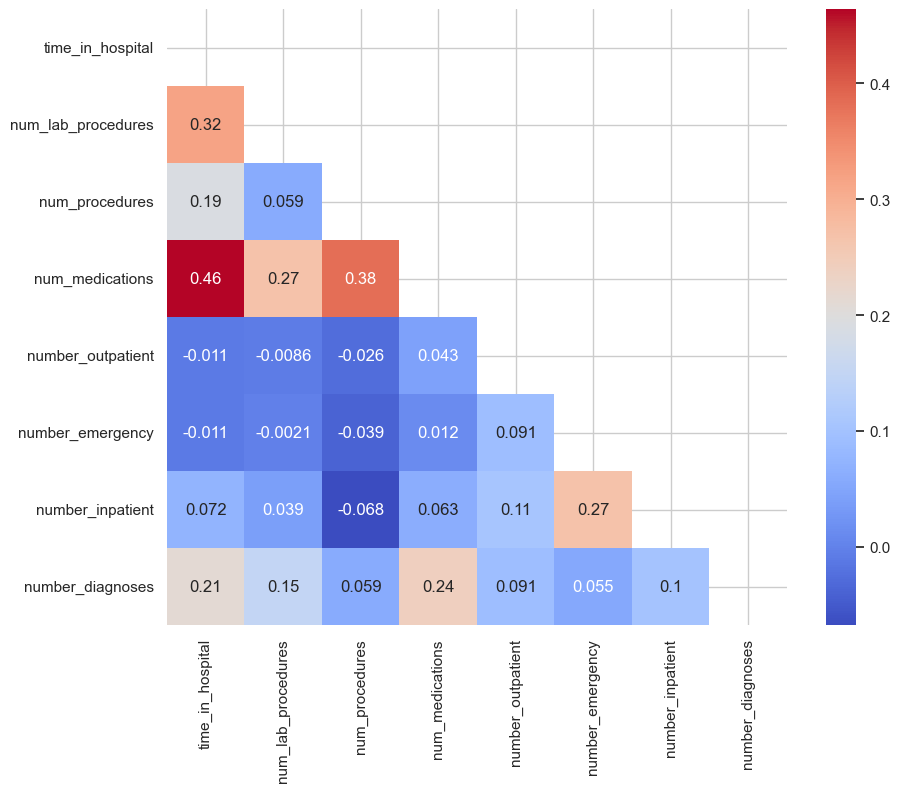

In [13]:
corr_pearson = df_diabetes_cleaned[var_numericas].corr(method='pearson')
mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

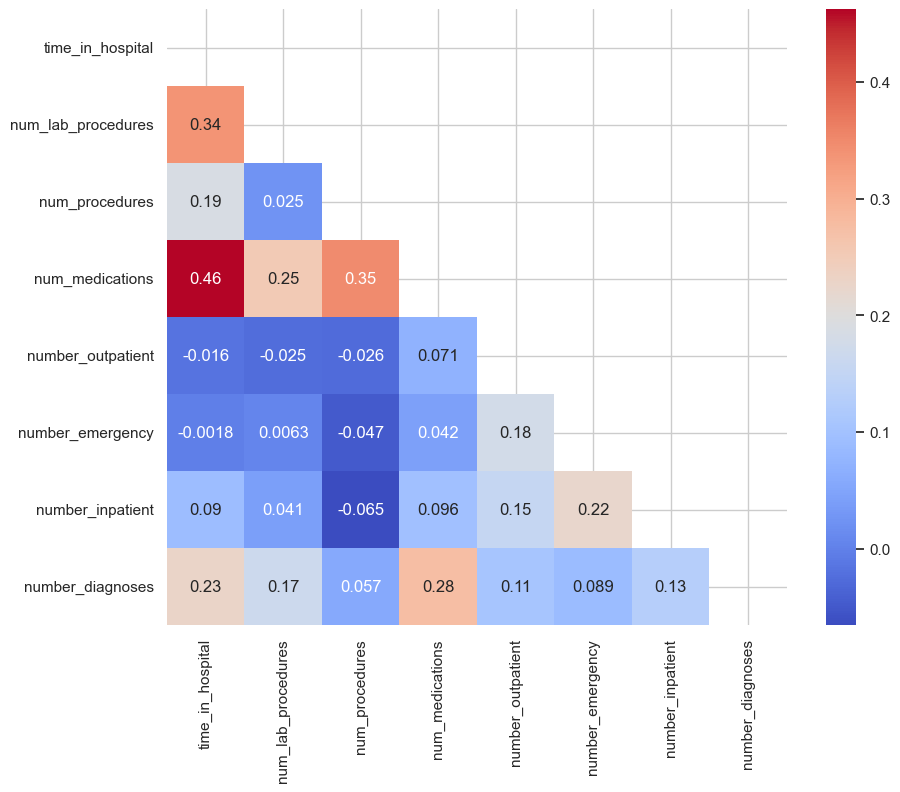

In [14]:
corr_spearman = df_diabetes_cleaned[var_numericas].corr(method='spearman')
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()


Se analiza que variables numericas tienen mas correlacion con la variable a predecir.

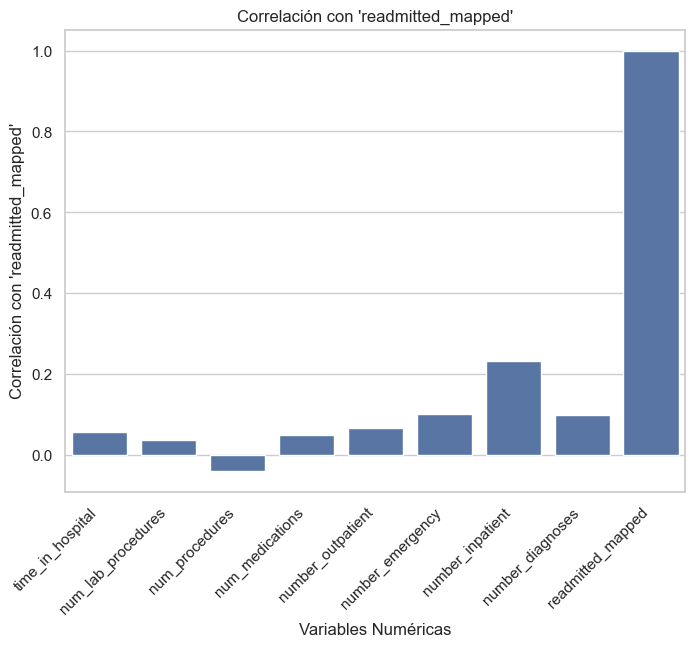

In [15]:
df_numeric = df_diabetes_cleaned[var_numericas].select_dtypes(include=['int64', 'float64'])
df_numeric['readmitted_mapped'] = df_diabetes_cleaned['readmitted_mapped']
correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_readmitted.index, y=correlation_with_readmitted.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables Numéricas")
plt.ylabel("Correlación con 'readmitted_mapped'")
plt.title("Correlación con 'readmitted_mapped'")
plt.show()

In [16]:
sorted_correlation = correlation_with_readmitted.sort_values(ascending=False)

print("Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):")
print(sorted_correlation)

Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):
readmitted_mapped     1.000000
number_inpatient      0.232208
number_emergency      0.102011
number_diagnoses      0.097494
number_outpatient     0.066619
time_in_hospital      0.055538
num_medications       0.048782
num_lab_procedures    0.036404
num_procedures       -0.039178
Name: readmitted_mapped, dtype: float64


### VARIABLES CATEGORICAS

##### Analisis *var_persona*

In [17]:
var_persona = ['race', 'gender', 'age']

In [18]:
for variable in var_persona:
    print(f"\nDistribución de valores para '{variable}':")
    print(df_diabetes_cleaned[variable].value_counts(normalize=True))


Distribución de valores para 'race':
race
Caucasian          0.765698
AfricanAmerican    0.192559
Hispanic           0.020234
Other              0.015135
Asian              0.006374
Name: proportion, dtype: float64

Distribución de valores para 'gender':
gender
Female             0.538821
Male               0.461169
Unknown/Invalid    0.000010
Name: proportion, dtype: float64

Distribución de valores para 'age':
age
[70-80)     0.258085
[60-70)     0.222421
[80-90)     0.170336
[50-60)     0.170285
[40-50)     0.094490
[30-40)     0.036185
[90-100)    0.027710
[20-30)     0.015073
[10-20)     0.004753
[0-10)      0.000663
Name: proportion, dtype: float64


Se elimina la row 'Unknown/Invalid' de la variable 'gender' ya que no aporta información y son solamente 2 datos.

In [19]:
count_unknown_invalid = df_diabetes_cleaned['gender'].value_counts().get('Unknown/Invalid', 0)
print(count_unknown_invalid)

1


In [20]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['gender'] == 'Unknown/Invalid'].index)

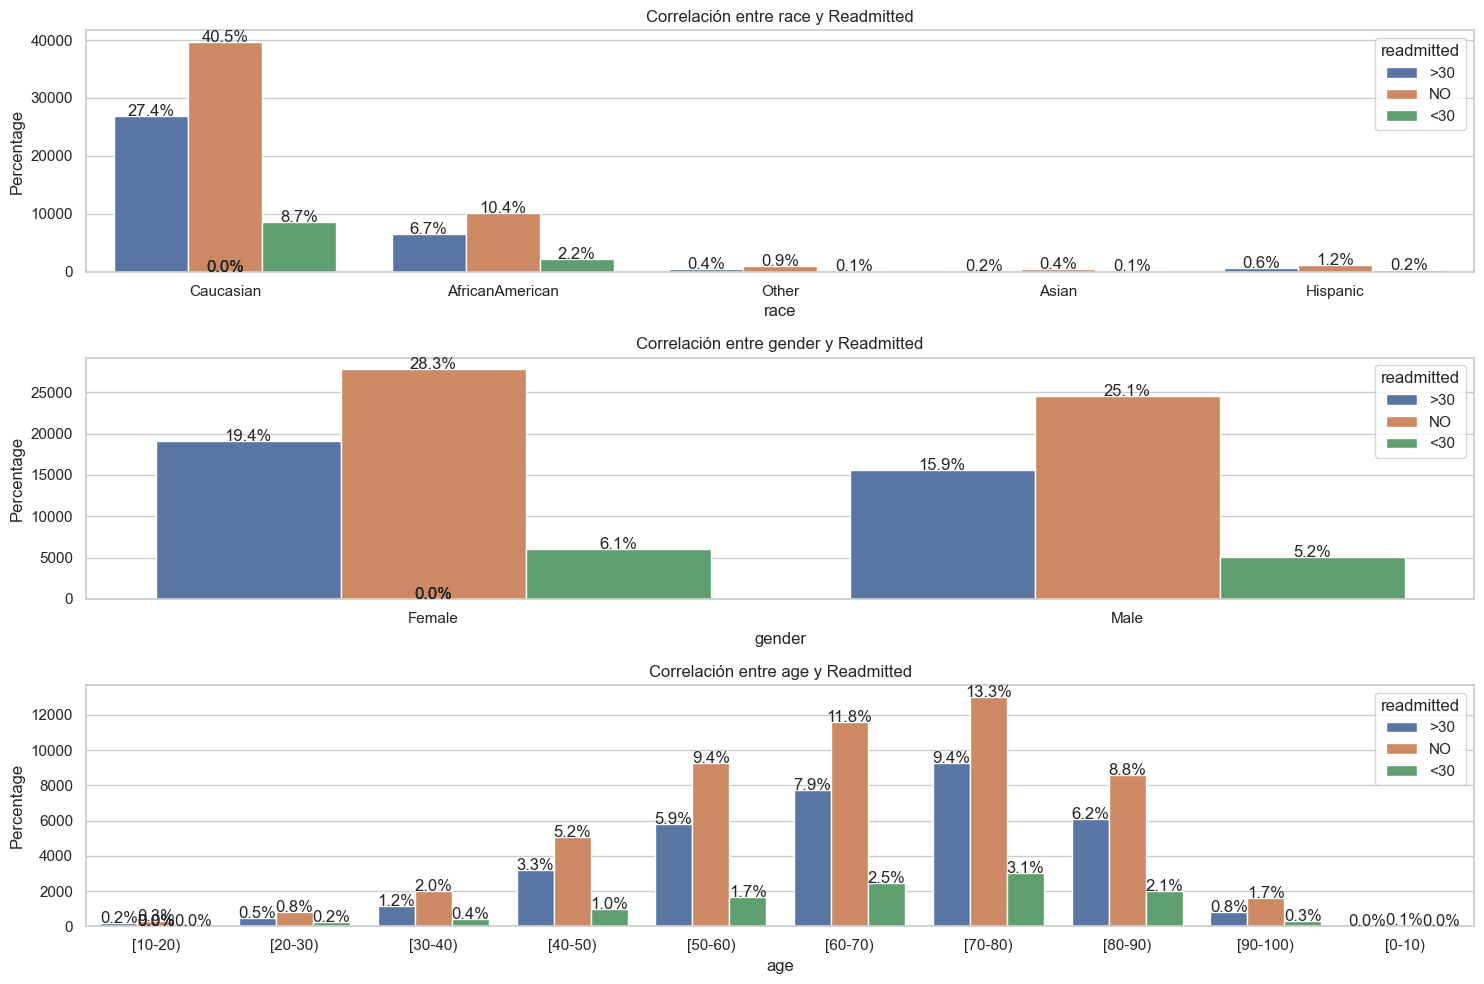

In [21]:
plt.figure(figsize=(15, 10))

for var in var_persona:
    plt.subplot(3, 1, var_persona.index(var) + 1)
    ax = sns.countplot(x=var, hue='readmitted', data=df_diabetes_cleaned, dodge=True) 
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Percentage') 

    total = len(df_diabetes_cleaned[var])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total:.1%}', ha="center")

plt.tight_layout()
plt.show()


##### Analisis *var_medicas*

In [22]:
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']

In [23]:
df_diabetes_cleaned['admission_type_id'].value_counts(normalize=True)

admission_type_id
1    0.532146
3    0.185544
2    0.178915
6    0.052370
5    0.047536
8    0.003182
7    0.000204
4    0.000102
Name: proportion, dtype: float64

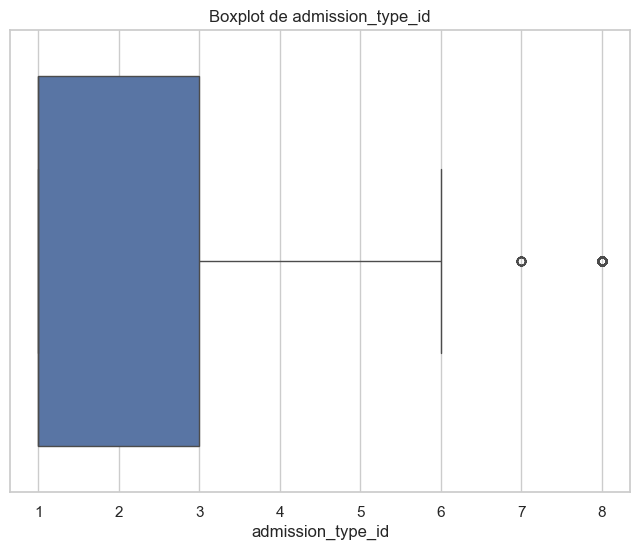

Q1: 1.0, Q3: 3.0, IQR: 2.0
Valores atípicos:
        encounter_id  patient_nbr             race  gender       age  \
7789        36234528     88040709  AfricanAmerican  Female   [60-70)   
8080        37183128     67488210  AfricanAmerican    Male   [50-60)   
8387        38036016     66182823        Caucasian  Female   [70-80)   
8718        39060678     90506502        Caucasian  Female   [50-60)   
8759        39142686     92729475        Caucasian    Male   [60-70)   
...              ...          ...              ...     ...       ...   
99507      414312614     55774188        Caucasian  Female  [90-100)   
100053     420802142    170447693        Caucasian    Male   [60-70)   
100742     430193132     70095330        Caucasian    Male   [80-90)   
100811     431339666    184871975        Caucasian    Male   [50-60)   
100867     431986772      3982338        Caucasian  Female   [70-80)   

        admission_type_id  discharge_disposition_id  admission_source_id  \
7789          

C:\Users\marti\AppData\Local\Temp\ipykernel_33288\3251174675.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_diabetes_cleaned[(df_diabetes['admission_type_id'] < lower_limit) | (df_diabetes_cleaned['admission_type_id'] > upper_limit)]


In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['admission_type_id'])
plt.title('Boxplot de admission_type_id')
plt.show()

Q1 = df_diabetes_cleaned['admission_type_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['admission_type_id'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes_cleaned[(df_diabetes['admission_type_id'] < lower_limit) | (df_diabetes_cleaned['admission_type_id'] > upper_limit)]
print('Valores atípicos:')
print(outliers)


*Se decide eliminar los outliers de la variable 'admission_type_id'*


*Al quitar el outlier "8" el modelo performa peor, por lo cual se decide mantenerlo.*

In [25]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 7].index)
#df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 8].index)
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 4].index)

In [26]:
df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True)

discharge_disposition_id
1     0.587603
3     0.138326
6     0.128736
18    0.036971
2     0.020893
22    0.020067
11    0.016353
5     0.011497
25    0.009600
4     0.007713
7     0.006039
23    0.004081
13    0.004040
14    0.003754
28    0.001398
8     0.001081
15    0.000643
24    0.000490
9     0.000214
17    0.000143
16    0.000112
19    0.000082
10    0.000061
27    0.000051
12    0.000031
20    0.000020
Name: proportion, dtype: float64

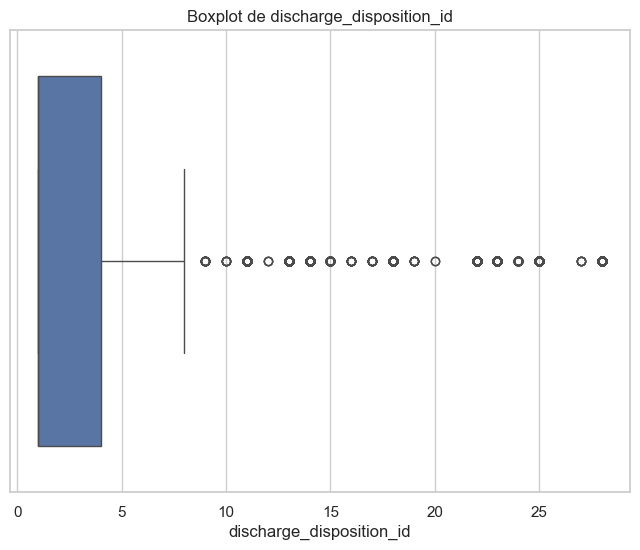

Q1: 1.0, Q3: 6.0, IQR: 5.0


In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['discharge_disposition_id'])
plt.title('Boxplot de discharge_disposition_id')
plt.show()

Q1 = df_diabetes_cleaned['discharge_disposition_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['discharge_disposition_id'].quantile(0.85)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes_cleaned[(df_diabetes_cleaned['discharge_disposition_id'] < lower_limit) | (df_diabetes_cleaned['discharge_disposition_id'] > upper_limit)]

In [28]:
outliers.shape[0]

7588

Se dan de baja las variables con menos de 0.1% de ocurrencia

In [29]:
values_to_drop = df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True)[df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True) < 0.001].index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['discharge_disposition_id'].isin(values_to_drop)]


In [30]:
df_diabetes_cleaned['admission_source_id'].value_counts(normalize=True)

admission_source_id
7     0.570875
1     0.289020
17    0.067211
4     0.030049
6     0.019348
2     0.010497
5     0.008626
3     0.001829
20    0.001635
9     0.000501
8     0.000153
22    0.000123
10    0.000072
11    0.000020
25    0.000020
14    0.000010
13    0.000010
Name: proportion, dtype: float64

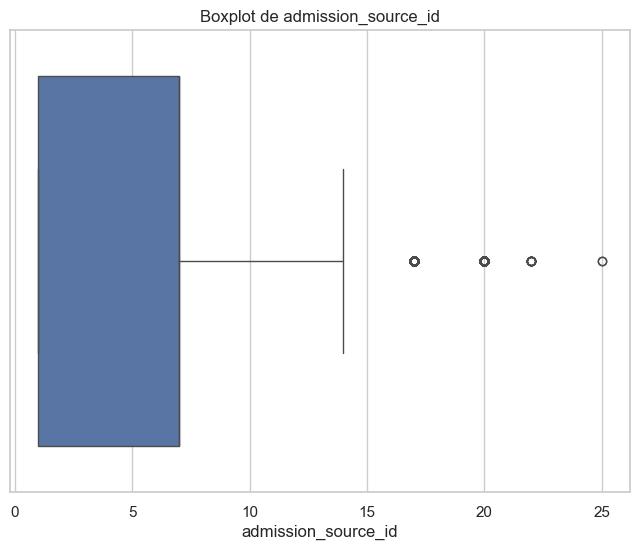

Q1: 1.0, Q3: 7.0, IQR: 6.0


In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['admission_source_id'])
plt.title('Boxplot de admission_source_id')
plt.show()

Q1 = df_diabetes_cleaned['admission_source_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['admission_source_id'].quantile(0.85)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_adm = df_diabetes_cleaned[(df_diabetes_cleaned['admission_source_id'] < lower_limit) | (df_diabetes_cleaned['admission_source_id'] > upper_limit)]

In [32]:
df_diabetes_cleaned['diag_1'].value_counts(normalize=True)

diag_1
428    0.068662
414    0.065116
786    0.039840
410    0.035895
486    0.034720
         ...   
216    0.000010
V43    0.000010
838    0.000010
955    0.000010
V51    0.000010
Name: proportion, Length: 712, dtype: float64

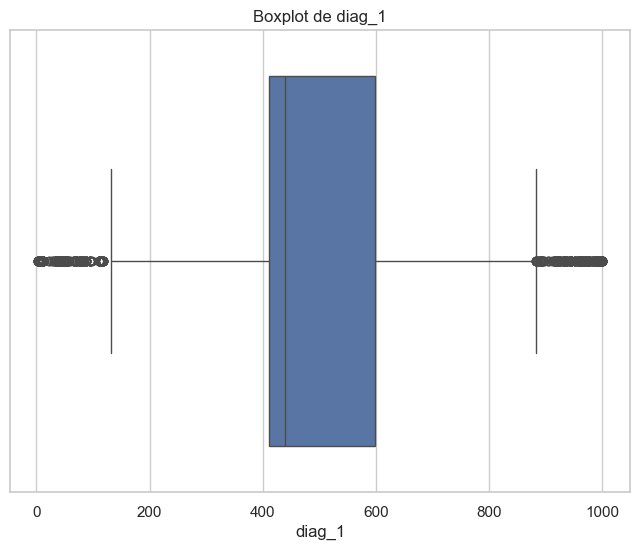

Q1: 296.0, Q3: 682.0, IQR: 386.0
Valores atípicos de diag_1:
[]


In [33]:
df_diabetes_numeric = pd.DataFrame()
df_diabetes_numeric['diag_1'] = pd.to_numeric(df_diabetes_cleaned['diag_1'], errors='coerce')


plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_1'])
plt.title('Boxplot de diag_1')
plt.show()

Q1 = df_diabetes_numeric['diag_1'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_1'].quantile(0.80)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag1 = df_diabetes_numeric[(df_diabetes_numeric['diag_1'] < lower_limit) | (df_diabetes_numeric['diag_1'] > upper_limit)]

print("Valores atípicos de diag_1:")
print(outliers_diag1['diag_1'].unique())

In [34]:
df_diabetes['diag_1'].value_counts(normalize=False)

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: count, Length: 716, dtype: int64

In [35]:
conteo_diag_1 = df_diabetes_cleaned['diag_1'].value_counts()

conteo_diag_1_filtrado = conteo_diag_1[conteo_diag_1 <= 5]

cantidad_total = conteo_diag_1_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 619
El porcentaje sobre el total de datos es: 0.00608258160878879


*Se decide quitar los registros con 5 o menos ocurrencias.*

In [36]:
registros_a_eliminar = conteo_diag_1_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['diag_1'].isin(registros_a_eliminar)]

In [37]:
df_diabetes_cleaned['diag_2'].value_counts(normalize=True)

diag_2
428    0.066631
276    0.066446
250    0.055276
427    0.050349
401    0.036926
         ...   
963    0.000010
915    0.000010
683    0.000010
944    0.000010
927    0.000010
Name: proportion, Length: 727, dtype: float64

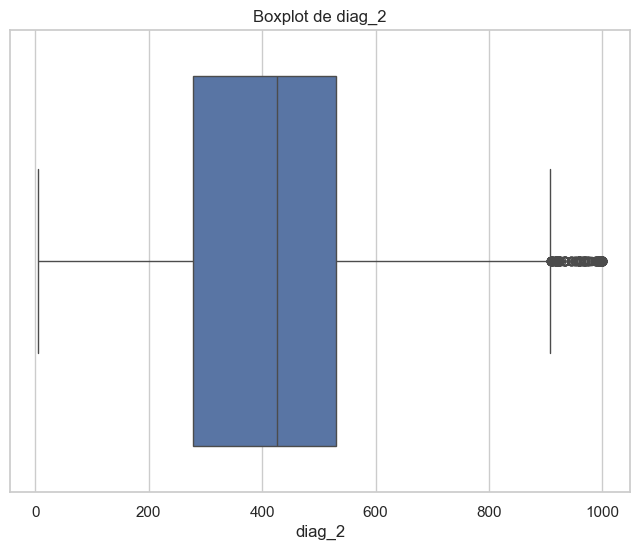

Valores atípicos de diag_2:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '571' '250.42' '807' '250.13'
 '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995' '235'
 '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281' '250.33'
 '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648' '566'
 '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202' '493'
 '280' '789' '154' '250.22' '441' '250.81' '962' '592' '707' '728' '618'
 '426' '569' '386' '337' '82' '531' '812' '225' '596' 'V58' '656' '433'
 '573' '492' '808' '958' '196' '112' '823' '532' '346' '162' '453' '535'
 '250' '595' '211' '303' '218' '540' '189' '285' '198' '304' '157' '537'
 '250.31' '250.23' 'V57' '805' '507' '934' '376' '413' '153' '293' '626'
 '553' '411' '496' '340' '621' '2

In [38]:
df_diabetes_numeric['diag_2'] = pd.to_numeric(df_diabetes_cleaned['diag_2'], errors='coerce')

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_2'])
plt.title('Boxplot de diag_2')
plt.show()

Q1 = df_diabetes_numeric['diag_2'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_2'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag2 = df_diabetes_numeric[(df_diabetes_numeric['diag_2'] < lower_limit) | (df_diabetes_numeric['diag_2'] > upper_limit)]

print("Valores atípicos de diag_2:")
print(outliers['diag_1'].unique())


In [39]:
df_diabetes_cleaned['diag_2'].value_counts(normalize=False)

diag_2
428    6478
276    6460
250    5374
427    4895
401    3590
       ... 
963       1
915       1
683       1
944       1
927       1
Name: count, Length: 727, dtype: int64

In [40]:
conteo_diag_2 = df_diabetes_cleaned['diag_2'].value_counts()

conteo_diag_2_filtrado = conteo_diag_2[conteo_diag_2 <= 5]

cantidad_total = conteo_diag_2_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 631
El porcentaje sobre el total de datos es: 0.006200499184403435


Se decide quitar los registros con 5 o menos ocurrencias.

In [41]:
registros_a_eliminar = conteo_diag_2_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_2'].isin(registros_a_eliminar)]

C:\Users\marti\AppData\Local\Temp\ipykernel_33288\8806830.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_2'].isin(registros_a_eliminar)]


In [42]:
df_diabetes_cleaned['diag_3'].value_counts(normalize=True)

diag_3
250     0.113830
401     0.082689
276     0.052210
428     0.046071
427     0.039735
          ...   
E815    0.000010
542     0.000010
E882    0.000010
E822    0.000010
971     0.000010
Name: proportion, Length: 768, dtype: float64

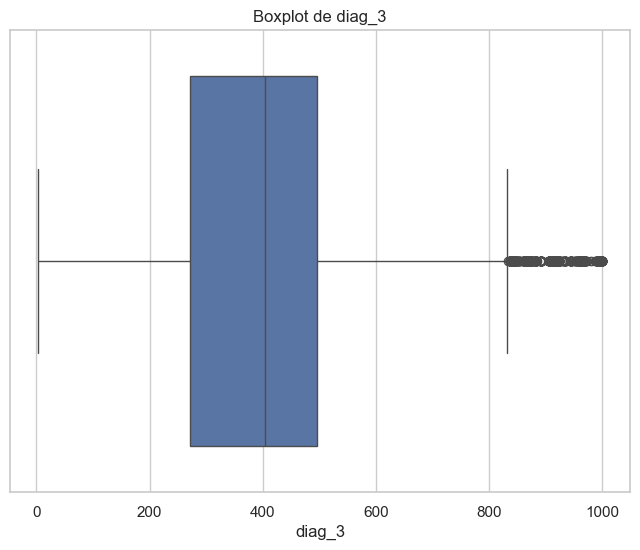

Valores atípicos de diag_3:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '571' '250.42' '807' '250.13'
 '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995' '235'
 '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281' '250.33'
 '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648' '566'
 '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202' '493'
 '280' '789' '154' '250.22' '441' '250.81' '962' '592' '707' '728' '618'
 '426' '569' '386' '337' '82' '531' '812' '225' '596' 'V58' '656' '433'
 '573' '492' '808' '958' '196' '112' '823' '532' '346' '162' '453' '535'
 '250' '595' '211' '303' '218' '540' '189' '285' '198' '304' '157' '537'
 '250.31' '250.23' 'V57' '805' '507' '934' '376' '413' '153' '293' '626'
 '553' '411' '496' '340' '621' '2

In [43]:
df_diabetes_numeric['diag_3'] = pd.to_numeric(df_diabetes_cleaned['diag_3'], errors='coerce')

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_3'])
plt.title('Boxplot de diag_3')
plt.show()

Q1 = df_diabetes_numeric['diag_3'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_3'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag3 = df_diabetes_numeric[(df_diabetes_numeric['diag_3'] < lower_limit) | (df_diabetes_numeric['diag_3'] > upper_limit)]

print("Valores atípicos de diag_3:")
print(outliers['diag_1'].unique())

In [44]:
df_diabetes_cleaned['diag_3'].value_counts(normalize=True)

diag_3
250     0.113830
401     0.082689
276     0.052210
428     0.046071
427     0.039735
          ...   
E815    0.000010
542     0.000010
E882    0.000010
E822    0.000010
971     0.000010
Name: proportion, Length: 768, dtype: float64

In [45]:
conteo_diag_3 = df_diabetes_cleaned['diag_3'].value_counts()

conteo_diag_3_filtrado = conteo_diag_3[conteo_diag_3 <= 5]

cantidad_total = conteo_diag_3_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 696
El porcentaje sobre el total de datos es: 0.006839219385649431


In [46]:
registros_a_eliminar = conteo_diag_3_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_3'].isin(registros_a_eliminar)]

C:\Users\marti\AppData\Local\Temp\ipykernel_33288\1947161449.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_3'].isin(registros_a_eliminar)]


In [47]:
print(len(df_diabetes_cleaned))

95895


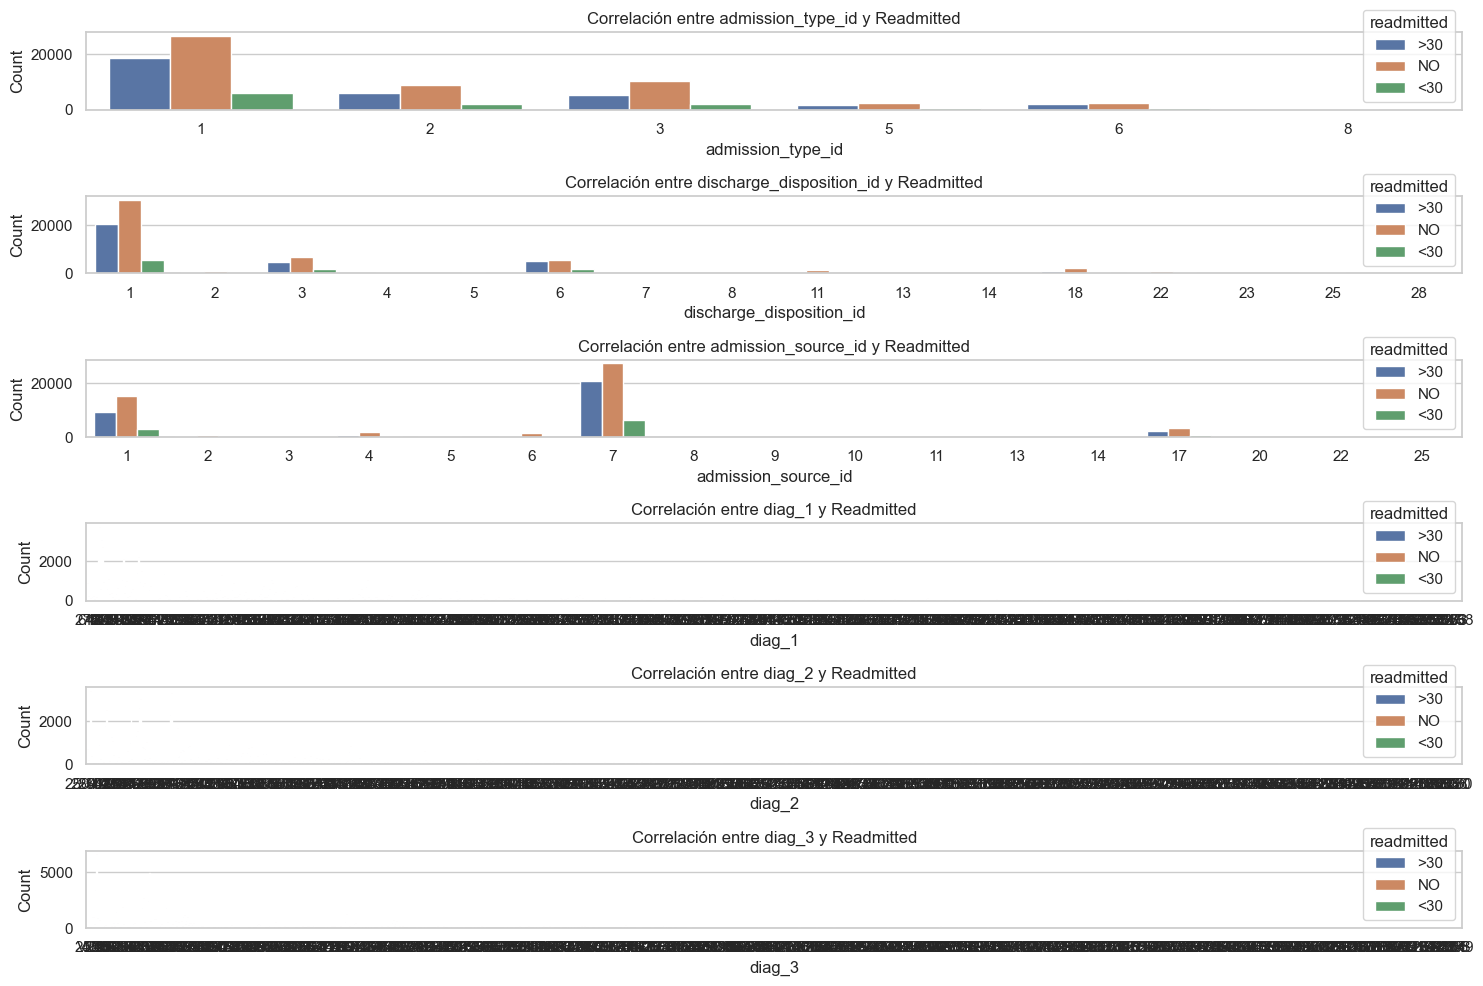

In [48]:
plt.figure(figsize=(15, 10))

for var in var_medicas:
    plt.subplot(6, 1, var_medicas.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes_cleaned, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

##### Analisis *var_medicine*

In [49]:
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

In [50]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin'].value_counts(normalize=False)}")


Porcentaje de valores unicos de: metformin
No        0.804432
Steady    0.179582
Up        0.010386
Down      0.005600
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin
No        77141
Steady    17221
Up          996
Down        537
Name: count, dtype: int64


In [51]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['repaglinide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['repaglinide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: repaglinide
No        0.984295
Steady    0.014140
Up        0.001095
Down      0.000469
Name: proportion, dtype: float64
Cantidad de valores unicos de: repaglinide
No        94389
Steady     1356
Up          105
Down         45
Name: count, dtype: int64


In [52]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['nateglinide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['nateglinide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: nateglinide
No        0.992919
Steady    0.006747
Up        0.000219
Down      0.000115
Name: proportion, dtype: float64
Cantidad de valores unicos de: nateglinide
No        95216
Steady      647
Up           21
Down         11
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [53]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['nateglinide'].isin(['Up', 'Down'])]

In [54]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['chlorpropamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['chlorpropamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: chlorpropamide
No        0.999155
Steady    0.000772
Up        0.000063
Down      0.000010
Name: proportion, dtype: float64
Cantidad de valores unicos de: chlorpropamide
No        95782
Steady       74
Up            6
Down          1
Name: count, dtype: int64


Se decide quitar la variable chlorpropamide porque el 99,9% de sus datos tienen el mismo valor.

In [55]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['chlorpropamide'],axis=1)

In [56]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glimepiride'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glimepiride'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glimepiride
No        0.949115
Steady    0.045742
Up        0.003255
Down      0.001888
Name: proportion, dtype: float64
Cantidad de valores unicos de: glimepiride
No        90985
Steady     4385
Up          312
Down        181
Name: count, dtype: int64


In [57]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['acetohexamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['acetohexamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: acetohexamide
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: acetohexamide
No        95862
Steady        1
Name: count, dtype: int64


Se decide quitar la variable acetohexamide porque el 99,9% de sus datos tienen el mismo valor.

In [58]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['acetohexamide'],axis=1)

In [59]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glipizide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glipizide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glipizide
No        0.874394
Steady    0.112369
Up        0.007657
Down      0.005581
Name: proportion, dtype: float64
Cantidad de valores unicos de: glipizide
No        83822
Steady    10772
Up          734
Down        535
Name: count, dtype: int64


In [60]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glyburide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glyburide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glyburide
No        0.895038
Steady    0.091370
Up        0.008053
Down      0.005539
Name: proportion, dtype: float64
Cantidad de valores unicos de: glyburide
No        85801
Steady     8759
Up          772
Down        531
Name: count, dtype: int64


In [61]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['tolbutamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['tolbutamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: tolbutamide
No        0.999791
Steady    0.000209
Name: proportion, dtype: float64
Cantidad de valores unicos de: tolbutamide
No        95843
Steady       20
Name: count, dtype: int64


Se decide quitar la variable tolbutamide porque el 99,9% de sus datos tienen el mismo valor.

In [62]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['tolbutamide'],axis=1)

In [63]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: pioglitazone
No        0.927511
Steady    0.069015
Up        0.002285
Down      0.001189
Name: proportion, dtype: float64
Cantidad de valores unicos de: pioglitazone
No        88914
Steady     6616
Up          219
Down        114
Name: count, dtype: int64


In [64]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['rosiglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['rosiglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: rosiglitazone
No        0.936993
Steady    0.060367
Up        0.001773
Down      0.000866
Name: proportion, dtype: float64
Cantidad de valores unicos de: rosiglitazone
No        89823
Steady     5787
Up          170
Down         83
Name: count, dtype: int64


In [65]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['acarbose'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['acarbose'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: acarbose
No        0.996944
Steady    0.002921
Up        0.000104
Down      0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: acarbose
No        95570
Steady      280
Up           10
Down          3
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [66]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['acarbose'].isin(['Up', 'Down'])]

In [67]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['miglitol'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['miglitol'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: miglitol
No        0.999614
Steady    0.000323
Down      0.000042
Up        0.000021
Name: proportion, dtype: float64
Cantidad de valores unicos de: miglitol
No        95813
Steady       31
Down          4
Up            2
Name: count, dtype: int64


Se decide quitar la variable miglitol porque el 99,9% de sus datos tienen el mismo valor.

In [68]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['miglitol'],axis=1)

In [69]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['troglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['troglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: troglitazone
No        0.999969
Steady    0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: troglitazone
No        95847
Steady        3
Name: count, dtype: int64


Se decide quitar la variable troglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [70]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['troglitazone'], axis=1)

In [71]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['tolazamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['tolazamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: tolazamide
No        0.999614
Steady    0.000376
Up        0.000010
Name: proportion, dtype: float64
Cantidad de valores unicos de: tolazamide
No        95813
Steady       36
Up            1
Name: count, dtype: int64


Se decide quitar la variable tolazamide porque el 99,9% de sus datos tienen el mismo valor.

In [72]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['tolazamide'], axis=1)

In [73]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['examide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['examide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: examide
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: examide
No    95850
Name: count, dtype: int64


Se decide quitar la variable examide porque el 99,9% de sus datos tienen el mismo valor.

In [74]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['examide'], axis=1)

In [75]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['citoglipton'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['citoglipton'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: citoglipton
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: citoglipton
No    95850
Name: count, dtype: int64


Se decide quitar la variable citoglipton porque el 99,9% de sus datos tienen el mismo valor.

In [76]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['citoglipton'],axis=1)

In [77]:
df_diabetes['insulin'].value_counts(normalize=False)
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['insulin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['insulin'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: insulin
No        0.468326
Steady    0.299238
Down      0.121377
Up        0.111059
Name: proportion, dtype: float64
Cantidad de valores unicos de: insulin
No        44889
Steady    28682
Down      11634
Up        10645
Name: count, dtype: int64


In [78]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glyburide-metformin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glyburide-metformin'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glyburide-metformin
No        0.993250
Steady    0.006667
Up        0.000052
Down      0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: glyburide-metformin
No        95203
Steady      639
Up            5
Down          3
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [79]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['glyburide-metformin'].isin(['Up', 'Down'])]

In [80]:
df_diabetes['glimepiride-pioglitazone'].value_counts(normalize=False)
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glimepiride-pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glimepiride-pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glimepiride-pioglitazone
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: glimepiride-pioglitazone
No        95841
Steady        1
Name: count, dtype: int64


Se decide quitar la variable glimepiride-pioglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [81]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['glimepiride-pioglitazone'],axis=1)

In [82]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin-rosiglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin-rosiglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: metformin-rosiglitazone
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin-rosiglitazone
No    95842
Name: count, dtype: int64


Se decide quitar la variable metformin-rosiglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [83]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['metformin-rosiglitazone'], axis=1)

In [84]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin-pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin-pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: metformin-pioglitazone
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin-pioglitazone
No        95841
Steady        1
Name: count, dtype: int64


Se decide quitar la variable metformin-pioglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [85]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['metformin-pioglitazone'], axis=1)

In [86]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['change'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['change'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: change
No    0.538
Ch    0.462
Name: proportion, dtype: float64
Cantidad de valores unicos de: change
No    51563
Ch    44279
Name: count, dtype: int64


In [87]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['diabetesMed'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['diabetesMed'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: diabetesMed
Yes    0.76888
No     0.23112
Name: proportion, dtype: float64
Cantidad de valores unicos de: diabetesMed
Yes    73691
No     22151
Name: count, dtype: int64


In [88]:
variables_iniciales = set(var_medicine)

columnas_df = set(df_diabetes_cleaned.columns)

variables_actuales = variables_iniciales.intersection(columnas_df)

print("Variables que aún existen en el DataFrame:", variables_actuales)
len(variables_actuales)

Variables que aún existen en el DataFrame: {'insulin', 'acarbose', 'glimepiride', 'metformin', 'glyburide', 'repaglinide', 'glipizide-metformin', 'glyburide-metformin', 'nateglinide', 'pioglitazone', 'diabetesMed', 'change', 'glipizide', 'rosiglitazone'}


14

In [89]:
var_medicine = ['nateglinide', 'diabetesMed', 'metformin', 'glyburide-metformin', 'rosiglitazone', 'glyburide', 'pioglitazone', 'glipizide', 
                'insulin', 'repaglinide', 'glimepiride', 'change', 'glipizide-metformin', 'acarbose']

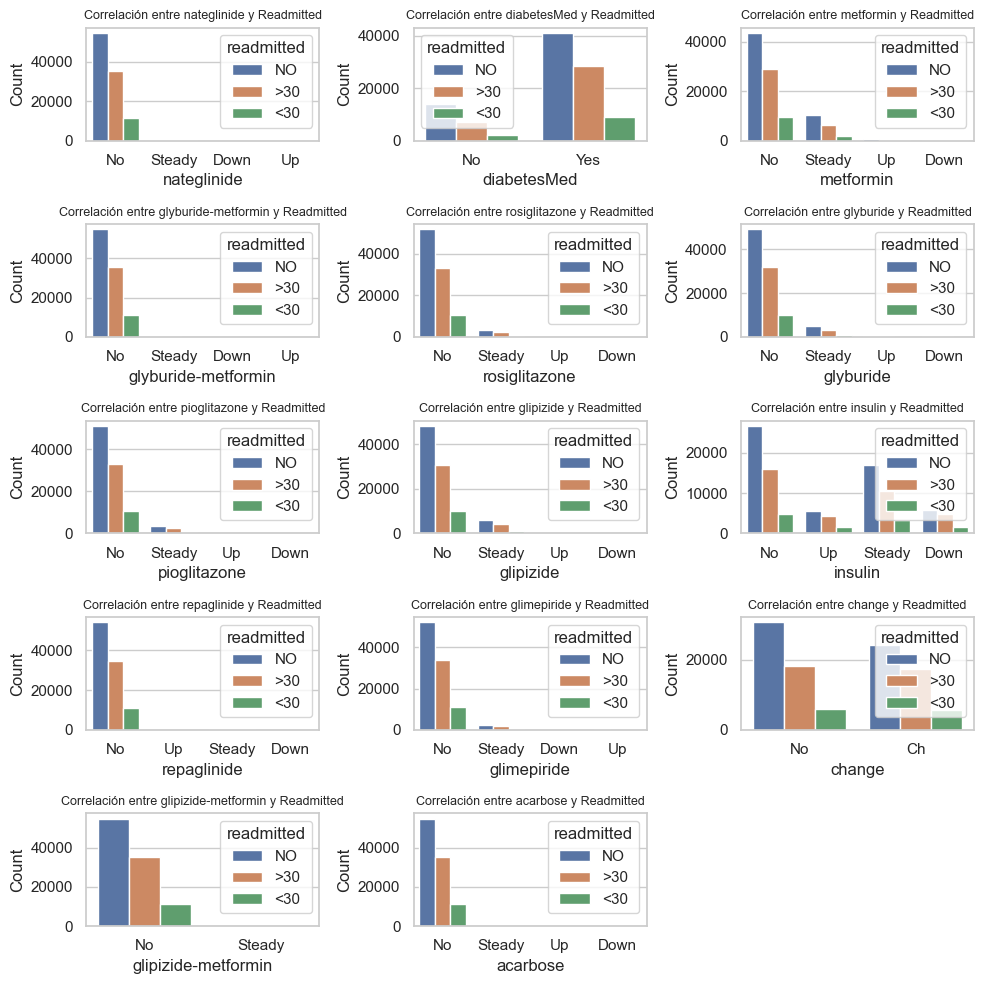

In [90]:
plt.figure(figsize=(10, 10))

for var in var_medicine:
    plt.subplot(5, 3, var_medicine.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted', fontsize=9)
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### SELECCION DE FEATURES

In [91]:
df_diabetes_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'change', 'diabetesMed',
       'readmitted', 'readmitted_mapped'],
      dtype='object')

In [92]:
var_persona = ['race', 'gender', 'age']
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                'num_medications', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'number_diagnoses']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
var_medicas_diag = ['diag_1', 'diag_2', 'diag_3']
var_medicine = ['nateglinide', 'diabetesMed', 'metformin', 'glyburide-metformin', 'rosiglitazone', 'glyburide', 'pioglitazone', 'glipizide', 
                'insulin', 'repaglinide', 'glimepiride', 'change', 'glipizide-metformin', 'acarbose']

var_objetivo = ['readmitted_mapped']

df_features = df_diabetes_cleaned[var_persona + var_numericas + var_medicas + var_medicas_diag + var_medicine + var_objetivo ].copy()

df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95842 entries, 1 to 101765
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      95842 non-null  object
 1   gender                    95842 non-null  object
 2   age                       95842 non-null  object
 3   time_in_hospital          95842 non-null  int64 
 4   num_lab_procedures        95842 non-null  int64 
 5   num_procedures            95842 non-null  int64 
 6   num_medications           95842 non-null  int64 
 7   number_outpatient         95842 non-null  int64 
 8   number_emergency          95842 non-null  int64 
 9   number_inpatient          95842 non-null  int64 
 10  number_diagnoses          95842 non-null  int64 
 11  admission_type_id         95842 non-null  int64 
 12  discharge_disposition_id  95842 non-null  int64 
 13  admission_source_id       95842 non-null  int64 
 14  diag_1                    

##### ONE HOT ENCODING

Se aplica One Hot Encoding a las variables categoricas para transformarlas en representaciones binarias y de esta forma lograr un mejor rendimiento de los modelos.

In [93]:
df_features = pd.get_dummies(df_features, columns=var_persona)

In [94]:
df_features = pd.get_dummies(df_features, columns=var_medicas)

In [95]:
df_features = pd.get_dummies(df_features, columns=var_medicas_diag)

In [96]:
df_features = pd.get_dummies(df_features, columns=var_medicine)

In [97]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95842 entries, 1 to 101765
Columns: 1484 entries, time_in_hospital to acarbose_Steady
dtypes: bool(1475), int64(9)
memory usage: 142.1 MB


##### STANDARD SCALER

Se aplica standard scaler para manejar una misma escala con todas las variables numericas

In [98]:
scaler = StandardScaler()

df_features[var_numericas] = scaler.fit_transform(df_features[var_numericas])

print(df_features[var_numericas].head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1         -0.476225            0.801029       -0.790270         0.228185   
2         -0.810146           -1.635027        2.128640        -0.387987   
3         -0.810146            0.039762       -0.206488        -0.018284   
4         -1.144067            0.395020       -0.790270        -1.004160   
5         -0.476225           -0.620003        2.712422        -0.018284   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
1          -0.293217         -0.215466         -0.510259          0.810497  
2           1.261815         -0.215466          0.273802         -0.828729  
3          -0.293217         -0.215466         -0.510259         -0.282320  
4          -0.293217         -0.215466         -0.510259         -1.375137  
5          -0.293217         -0.215466         -0.510259          0.810497  


Se divide el dataset en conjuntos de entrenamiento y prueba.

In [99]:
X = df_features.drop('readmitted_mapped', axis=1)
y = df_features['readmitted_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Se genera un modelo Random Forest ya que es un modelo comunmente utilizado en porblemas de clasificacion multiclase, y ademas es bueno en casos de clases desbalanceadas.

In [100]:
rf_1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)

rf_1.fit(X_train, y_train)

y_pred = rf_1.predict(X_test)

#AUC-ROC
y_pred_ar = rf_1.predict_proba(X_test)

auc_roc = roc_auc_score(y_test, y_pred_ar, multi_class='ovr')

print("Matriz de Confusión rf_1:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación rf_1:")
print(classification_report(y_test, y_pred))

print(f'\nAUC-ROC: {auc_roc:.4f}')

Matriz de Confusión rf_1:
[[12102   665     0]
 [ 7013  1467     0]
 [ 2203   511     0]]

Reporte de Clasificación rf_1:
              precision    recall  f1-score   support

           1       0.57      0.95      0.71     12767
           2       0.56      0.17      0.26      8480
           3       0.00      0.00      0.00      2714

    accuracy                           0.57     23961
   macro avg       0.37      0.37      0.32     23961
weighted avg       0.50      0.57      0.47     23961


AUC-ROC: 0.6739


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Se genera un nuevo modelo Random Forest pero esta vez aplicando la tecninca SMOTE, la cual sirve para abordar la problematica de desbalanceo de clases que presenta el caso.

In [101]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_1_resampled = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=10, 
    random_state=42, 
    class_weight="balanced_subsample"
)

rf_1_resampled.fit(X_train_resampled, y_train_resampled)

y_pred_resampled = rf_1_resampled.predict(X_test)

print("Matriz de Confusión (con sobremuestreo SMOTE):")
print(confusion_matrix(y_test, y_pred_resampled))

print("\nReporte de Clasificación (con sobremuestreo SMOTE):")
print(classification_report(y_test, y_pred_resampled))

y_pred_ar_resampled = rf_1_resampled.predict_proba(X_test)
auc_roc_resampled = roc_auc_score(y_test, y_pred_ar_resampled, multi_class='ovr')
print(f'\nAUC-ROC (con sobremuestreo SMOTE): {auc_roc_resampled:.4f}')

Matriz de Confusión (con sobremuestreo SMOTE):
[[9505 2691  571]
 [4285 3485  710]
 [1248 1048  418]]

Reporte de Clasificación (con sobremuestreo SMOTE):
              precision    recall  f1-score   support

           1       0.63      0.74      0.68     12767
           2       0.48      0.41      0.44      8480
           3       0.25      0.15      0.19      2714

    accuracy                           0.56     23961
   macro avg       0.45      0.44      0.44     23961
weighted avg       0.54      0.56      0.54     23961


AUC-ROC (con sobremuestreo SMOTE): 0.6621


In [102]:
feature_importances = rf_1_resampled.feature_importances_

num_features = sum(feature_importances > 0)

print(f"El modelo RandomForestClassifier tiene {num_features} features.")

El modelo RandomForestClassifier tiene 1464 features.


In [103]:
feature_importance = rf_1_resampled.feature_importances_
indices_ordenados = np.argsort(feature_importance)[::-1]
feature_importance_ordenada = feature_importance[indices_ordenados]
nombres_variables = X_train_resampled.columns

In [104]:
for i, feature in enumerate(X_train_resampled.columns):
    if(i<1465):
        print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: time_in_hospital - Importancia: 0.10013677387322004
Característica: num_lab_procedures - Importancia: 0.03659286448307439
Característica: num_procedures - Importancia: 0.03202512242787642
Característica: num_medications - Importancia: 0.03146051204916069
Característica: number_outpatient - Importancia: 0.029001864954180022
Característica: number_emergency - Importancia: 0.02773557147797246
Característica: number_inpatient - Importancia: 0.02767777705871944
Característica: number_diagnoses - Importancia: 0.025363647515195018
Característica: race_AfricanAmerican - Importancia: 0.018874407333791875
Característica: race_Asian - Importancia: 0.018795274981099862
Característica: race_Caucasian - Importancia: 0.0166697888366518
Característica: race_Hispanic - Importancia: 0.014901330518275328
Característica: race_Other - Importancia: 0.014815862086012089
Característica: gender_Female - Importancia: 0.014516606586079495
Característica: gender_Male - Importancia: 0.0111007927831

Se mantienen solamente las features con un una importancia mayor a 0.3%.

In [105]:
features_to_keep = [feature for feature, importance in zip(X_train_resampled.columns, feature_importances) if importance >= 0.003]

X_train_filtered = X_train_resampled[features_to_keep]
X_test_filtered = X_test[features_to_keep]

Se procede a generar un grid para determinar cuales son los valores de hiperparametros optimos para el desempeño del modelo.

In [498]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'class_weight':['balanced_subsample']
}

rf_grid = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_filtered, y_train_resampled)

print("Mejores hiperparámetros:", grid_search.best_params_)

rf_grid = grid_search.best_estimator_

y_pred_best_params = rf_grid.predict(X_test_filtered)

Mejores hiperparámetros: {'class_weight': 'balanced_subsample', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}


Se genera un nuevo modelo (rf_2) con las features previamente filtradas y los hiperparametros obtenidos del grid anterior.

In [106]:
rf_2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced_subsample'
)

rf_2.fit(X_train_filtered, y_train_resampled)

y_pred_filtered = rf_2.predict(X_test_filtered)

y_pred_au_filtered = rf_2.predict_proba(X_test_filtered)

auc_roc_filtered = roc_auc_score(y_test, y_pred_au_filtered, multi_class='ovr')

print("Matriz de Confusión (con características filtradas):")
print(confusion_matrix(y_test, y_pred_filtered))

print("\nReporte de Clasificación (con características filtradas):")
print(classification_report(y_test, y_pred_filtered))

print(f'\nAUC-ROC (con características filtradas): {auc_roc_filtered:.4f}')

Matriz de Confusión (con características filtradas):
[[9851 2742  174]
 [4600 3646  234]
 [1377 1128  209]]

Reporte de Clasificación (con características filtradas):
              precision    recall  f1-score   support

           1       0.62      0.77      0.69     12767
           2       0.49      0.43      0.46      8480
           3       0.34      0.08      0.13      2714

    accuracy                           0.57     23961
   macro avg       0.48      0.43      0.42     23961
weighted avg       0.54      0.57      0.54     23961


AUC-ROC (con características filtradas): 0.6575


Se obtienen nuevamente cuales son las features de mayor importancia, esta vez para el modelo rf2.

In [116]:
feature_importances_rf2 = rf_2.feature_importances_

num_features = sum(feature_importances_rf2 > 0)

print(f"El modelo RandomForestClassifier tiene {num_features} features.")

El modelo RandomForestClassifier tiene 68 features.


In [120]:
indices_ordenados = np.argsort(feature_importances_rf2)[::-1]
feature_importance_rf2_ordenada = feature_importances_rf2[indices_ordenados]
nombres_variables_rf2 = X_train_filtered.columns

In [118]:
for i, feature in enumerate(X_train_filtered.columns):
    if(i<69):
        print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: time_in_hospital - Importancia: 0.10013677387322004
Característica: num_lab_procedures - Importancia: 0.03659286448307439
Característica: num_procedures - Importancia: 0.03202512242787642
Característica: num_medications - Importancia: 0.03146051204916069
Característica: number_outpatient - Importancia: 0.029001864954180022
Característica: number_emergency - Importancia: 0.02773557147797246
Característica: number_inpatient - Importancia: 0.02767777705871944
Característica: number_diagnoses - Importancia: 0.025363647515195018
Característica: race_AfricanAmerican - Importancia: 0.018874407333791875
Característica: race_Caucasian - Importancia: 0.018795274981099862
Característica: gender_Female - Importancia: 0.0166697888366518
Característica: gender_Male - Importancia: 0.014901330518275328
Característica: age_[40-50) - Importancia: 0.014815862086012089
Característica: age_[50-60) - Importancia: 0.014516606586079495
Característica: age_[60-70) - Importancia: 0.0111007927831

Se genera un tercer modelo para evaluar su desempeño, esta vez en lugar de usar Random Forest, se utiliza Gradient Boosting Classifier.

Este construye arboles de forma secuencial, intentando corregir los errores cometidos por arboles anteriores, ademas es muy eficiente en casos de desbalanceo de clases.

In [503]:
gb_model = GradientBoostingClassifier(n_estimators=300, max_depth=30, random_state=42)

gb_model.fit(X_train_filtered, y_train_resampled)

y_pred_gb = gb_model.predict(X_test_filtered)

auc_roc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test_filtered), multi_class='ovo')

print("Matriz de Confusión (con Gradient Boosting):")
print(confusion_matrix(y_test, y_pred_gb))

print("\nReporte de Clasificación (con Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

print(f'\nAUC-ROC (con Gradient Boosting): {auc_roc_gb:.4f}')

Matriz de Confusión (con Gradient Boosting):
[[9857 2613  297]
 [4990 3105  385]
 [1506  992  216]]

Reporte de Clasificación (con Gradient Boosting):
              precision    recall  f1-score   support

           1       0.60      0.77      0.68     12767
           2       0.46      0.37      0.41      8480
           3       0.24      0.08      0.12      2714

    accuracy                           0.55     23961
   macro avg       0.44      0.41      0.40     23961
weighted avg       0.51      0.55      0.52     23961


AUC-ROC (con Gradient Boosting): 0.6105


Finalmente se aplica la tecnica de stacking para combinar el modelo Random Forest 2 y el modelo Gradient Boosting con el fin de intentar un mejor resultado gracias a la combinacion del aprendizaje de ambos modelos.

In [654]:
meta_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced_subsample'
)

model_stacking = StackingClassifier(
    estimators=[('rf', rf_2), ('gb', gb_model)],
    final_estimator=meta_model
)

model_stacking.fit(X_train_filtered, y_train_resampled)

y_pred_filtered_mm = model_stacking.predict(X_test_filtered)
y_pred_ar_filtered_mm = model_stacking.predict_proba(X_test_filtered)

auc_roc_ms = roc_auc_score(y_test, y_pred_ar_filtered_mm, multi_class='ovr')

print("Matriz de Confusión (con características filtradas):")
print(confusion_matrix(y_test, y_pred_filtered_mm))

print("\nReporte de Clasificación (con características filtradas):")
print(classification_report(y_test, y_pred_filtered_mm))

print(f'\nAUC-ROC (con características filtradas): {auc_roc_ms:.4f}')

#### COMPARACION DE PERFORMANCES DE MODELOS

##### RANDOM FOREST 1

In [542]:
classification_report_str = classification_report(y_test, y_pred_resampled)

weighted_avg_line = [line for line in classification_report_str.split('\n') if 'weighted avg' in line][0]

values = re.findall(r'\d+\.\d+', weighted_avg_line)

precision_w_avg_rf1, recall_w_avg_rf1, f1_w_avg_rf1 = map(float, values)
print(f'Precision (weighted avg): {precision_w_avg_rf1:.4f}')
print(f'Recall (weighted avg): {recall_w_avg_rf1:.4f}')
print(f'F1-Score (weighted avg): {f1_w_avg_rf1:.4f}')
print(f'AUC-ROC (RF1): {auc_roc_resampled:.4f}')

Precision (weighted avg): 0.5400
Recall (weighted avg): 0.5600
F1-Score (weighted avg): 0.5400
AUC-ROC (RF1): 0.6621


##### RANDOM FOREST 2

In [541]:
classification_report_str = classification_report(y_test, y_pred_filtered)

weighted_avg_line = [line for line in classification_report_str.split('\n') if 'weighted avg' in line][0]
values = re.findall(r'\d+\.\d+', weighted_avg_line)

precision_w_avg_rf2, recall_w_avg_rf2, f1_w_avg_rf2 = map(float, values)
print(f'Precision (weighted avg): {precision_w_avg_rf2:.4f}')
print(f'Recall (weighted avg): {recall_w_avg_rf2:.4f}')
print(f'F1-Score (weighted avg): {f1_w_avg_rf2:.4f}')
print(f'AUC-ROC (RF2): {auc_roc_filtered:.4f}')

Precision (weighted avg): 0.5400
Recall (weighted avg): 0.5700
F1-Score (weighted avg): 0.5400
AUC-ROC (RF2): 0.6575


##### GRADIENT BOOSTING CLASSIFIER

In [540]:
classification_report_str = classification_report(y_test, y_pred_gb)

weighted_avg_line = [line for line in classification_report_str.split('\n') if 'weighted avg' in line][0]

values = re.findall(r'\d+\.\d+', weighted_avg_line)

precision_w_avg_gb, recall_w_avg_gb, f1_w_avg_gb = map(float, values)
print(f'Precision (weighted avg): {precision_w_avg_gb:.4f}')
print(f'Recall (weighted avg): {recall_w_avg_gb:.4f}')
print(f'F1-Score (weighted avg): {f1_w_avg_gb:.4f}')
print(f'AUC-ROC (GB): {auc_roc_gb:.4f}')

Precision (weighted avg): 0.5100
Recall (weighted avg): 0.5500
F1-Score (weighted avg): 0.5200
AUC-ROC (GB): 0.6105


##### MODEL STACKING

In [543]:
classification_report_str = classification_report(y_test, y_pred_filtered_mm)

weighted_avg_line = [line for line in classification_report_str.split('\n') if 'weighted avg' in line][0]

values = re.findall(r'\d+\.\d+', weighted_avg_line)

precision_w_avg_ms, recall_w_avg_ms, f1_w_avg_ms = map(float, values)
print(f'Precision (weighted avg): {precision_w_avg_ms:.4f}')
print(f'Recall (weighted avg): {recall_w_avg_ms:.4f}')
print(f'F1-Score (weighted avg): {f1_w_avg_ms:.4f}')
print(f'AUC-ROC (MS): {auc_roc_ms:.4f}')

Precision (weighted avg): 0.5100
Recall (weighted avg): 0.5500
F1-Score (weighted avg): 0.5100
AUC-ROC (MS): 0.6575


In [544]:
resultados_rf_1 = []
resultados_rf_2 = []
resultados_gb_model = []
resultados_model_stacking=[]

In [545]:
resultados_rf_1.append(precision_w_avg_rf1)
resultados_rf_1.append(recall_w_avg_rf1)
resultados_rf_1.append(f1_w_avg_rf1)
resultados_rf_1.append(auc_roc_resampled)

resultados_rf_2.append(precision_w_avg_rf2)
resultados_rf_2.append(recall_w_avg_rf2)
resultados_rf_2.append(f1_w_avg_rf2)
resultados_rf_2.append(auc_roc_filtered)

resultados_gb_model.append(precision_w_avg_gb)
resultados_gb_model.append(recall_w_avg_gb)
resultados_gb_model.append(f1_w_avg_gb)
resultados_gb_model.append(auc_roc_gb)

resultados_model_stacking.append(precision_w_avg_ms)
resultados_model_stacking.append(recall_w_avg_ms)
resultados_model_stacking.append(f1_w_avg_ms)
resultados_model_stacking.append(auc_roc_filtered)

In [546]:
resultados = pd.DataFrame(
    {'resultados_rf_1_resampled': resultados_rf_1,
    'resultados_rf_2': resultados_rf_2,
    'resultados_gb_model': resultados_gb_model,
    'resultados_model_stacking': resultados_model_stacking,
    })

resultados = resultados.rename(index={0: 'precision', 1: 'recall', 2: 'f1', 3: 'AUC-ROC'})

In [547]:
resultados

,resultados_rf_1_resampled,resultados_rf_2,resultados_gb_model,resultados_model_stacking
precision,0.540000,0.540000,0.51000,0.510000
recall,0.560000,0.570000,0.55000,0.550000
f1,0.540000,0.540000,0.52000,0.510000
AUC-ROC,0.662074,0.657466,0.61052,0.657466


Como se puede ver, los modelos que mejor performan son los RANDOM FOREST 1 y 2. 

En el modelo RF1 se aplicó la técnica SMOTE para mejorar el rendimiento ya que la variable objetivo se encuentra desbalanceada.

Mientras que en el modelo RF2 se realizó el analisis de feature_importance, para de esta forma utilizar solamente las features que fueran más relevantes para el modelo. Si bien esto no generó mejorias en cuanto a la curva AUC-ROC, si mostró una leve mejora en el parametro recall, el cual mide la tasa de predicciones positivas correctas sobre la cantidad total de casos positivos.

En el caso analizado se puede interpretar como los casos predichos correctamente como readmisiones en menos de 30 dias sobre el total de readmisiones en menos de 30 dias (esto aplica para cada una de las 3 clases de la variable objetivo).

Finalmente se deja un grafico de barras mostrando cuales son las features más relevantes en el modelo RANDOM FOREST 2. Esto puede servir para sacar conclusiones de cuales son los factores a considerar al momento de determinar el comportamiento a futuro de cada paciente.

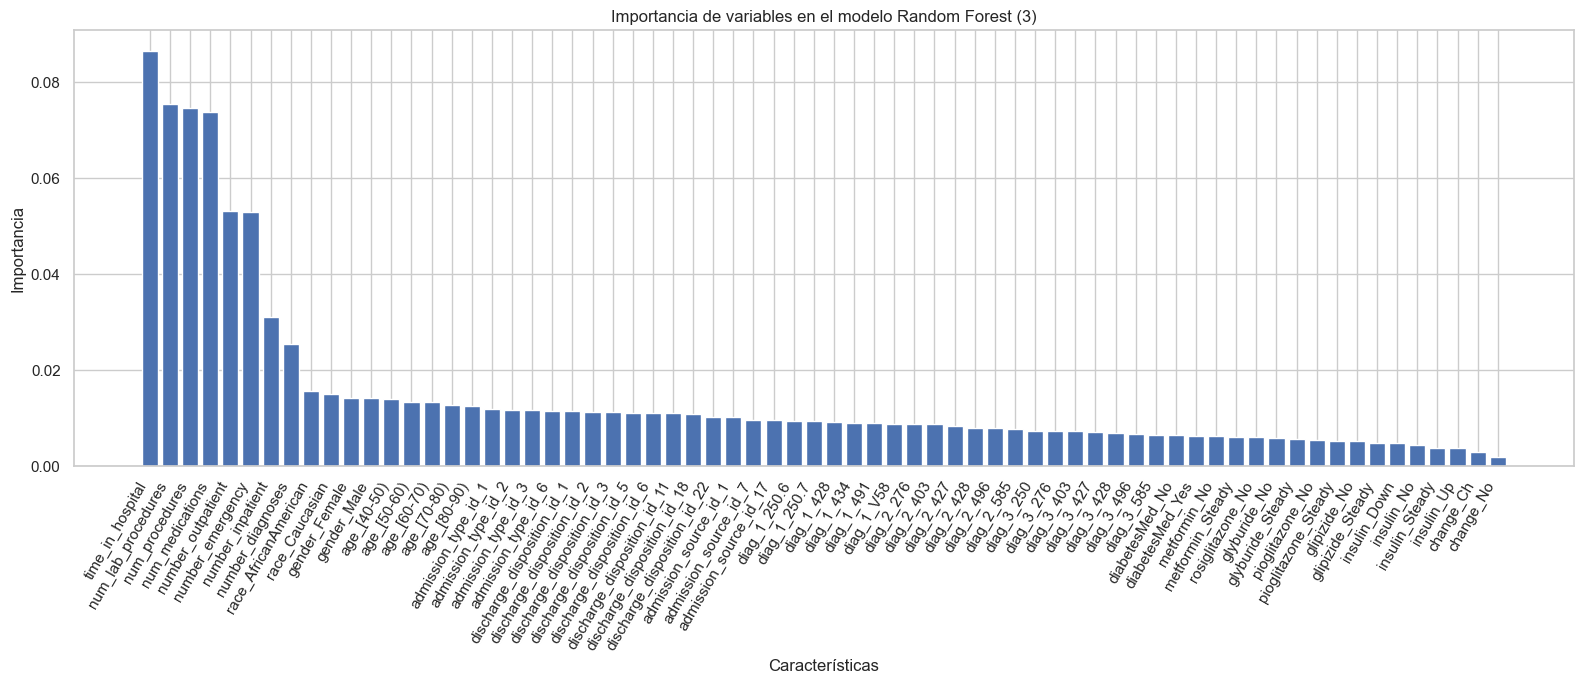

In [122]:
plt.figure(figsize=(16, 7))
plt.bar(range(len(nombres_variables_rf2)), feature_importance_rf2_ordenada)
plt.xticks(range(len(nombres_variables_rf2)), nombres_variables_rf2, rotation=60, ha='right')
plt.title('Importancia de variables en el modelo Random Forest (3)')
plt.xlabel('Características')
plt.ylabel('Importancia')

plt.tight_layout()
plt.show()